*La base des TDs pour le cours "Analyse de données massives 2" a été prise du cours en ligne "Open Machine Learning Course" (https://mlcourse.ai/, auteur Yury Kashnitsky)*

# <center> TD 4 : Apprentissage non supervisé: PCA et clustering

Aujourd'hui, nous allons travailler avec des méthodes d'apprentissage non supervisées telles que l'analyse en composantes principales (ACP) et le clustering. Vous apprendrez pourquoi et comment nous pouvons réduire la dimensionnalité des données d'origine et quelles sont les principales approches pour regrouper des points de données similaires.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns 
sns.set()
# sns.set(style='white')

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Analyse en composantes principales (ACP)

L'analyse en composantes principales est l'une des méthodes les plus simples, les plus intuitives et les plus utilisées pour réduire la dimensionnalité, projetant des données sur son sous-espace d'entités orthogonales.


<img align="right" src="https://habrastorage.org/getpro/habr/post_images/bb6/fe7/f06/bb6fe7f06e114bcc9c354a1cb025b966.png" width="400">


Plus généralement, toutes les observations peuvent être considérées comme un ellipsoïde dans un sous-espace d'un espace caractéristique initial, et la nouvelle base définie dans ce sous-espace est alignée avec les axes ellipsoïdes. Cette hypothèse nous permet de supprimer les caractéristiques hautement corrélées puisque les vecteurs d'ensemble de base sont orthogonaux.
Dans le cas général, la dimensionnalité ellipsoïde résultante correspond à la dimensionnalité spatiale initiale, mais l'hypothèse que nos données se trouvent dans un sous-espace avec une dimension plus petite nous permet de couper l'espace "excessif" avec la nouvelle projection (sous-espace). 

### A. Exemple : Ensemble de données sur l'iris de Fisher

Commençons par télécharger tous les modules essentiels et essayons l'exemple iris de la documentation `scikit-learn`.

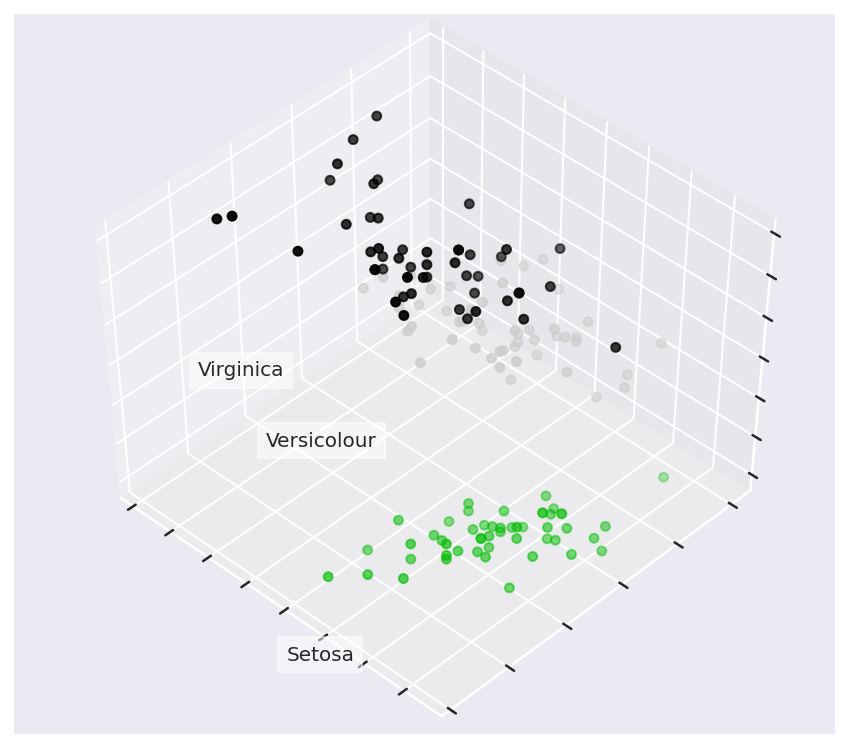

In [ ]:
from sklearn import decomposition
from sklearn import datasets

# Loading the dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Let's create a beautiful 3d-plot
fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Change the order of labels, so that they match
y_clr = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_clr, 
           cmap=plt.cm.nipy_spectral)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([]);

Voyons maintenant comment PCA améliorera les résultats d'un modèle simple qui n'est pas capable d'ajuster correctement toutes les données d'entraînement:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Train, test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

# Decision trees with depth = 2
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.88889


Essayons à nouveau, mais, cette fois, réduisons la dimensionnalité à 2 dimensions:

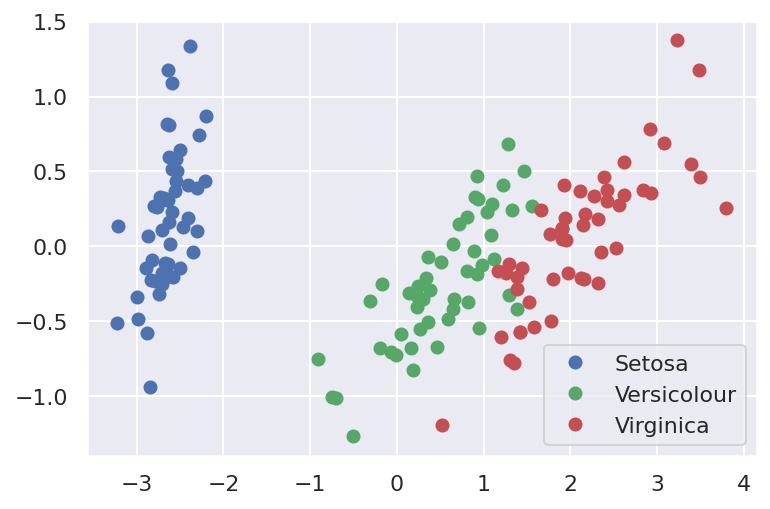

In [ ]:
# Using PCA from sklearn PCA
pca = decomposition.PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

# Plotting the results of PCA
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Setosa')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='Versicolour')
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='Virginica')
plt.legend(loc=0);

In [ ]:
# Test-train split and apply PCA
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.91111


La précision n'a pas augmenté de manière significative dans ce cas, mais, avec d'autres ensembles de données avec un nombre élevé de dimensions, l'ACP peut considérablement améliorer la précision des arbres de décision et d'autres méthodes d'ensemble.

Voyons maintenant le pourcentage de variance qui peut être expliqué par chacun des composants sélectionnés.

In [ ]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))

1 component: 92.46% of initial variance
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
2 component: 5.31% of initial variance
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


### B. Exemple : Ensemble de données de nombres manuscrits

Regardons l'ensemble de données de nombres manuscrits que nous avons utilisé semaine dernière.

In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target

X[0,:].reshape([8,8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Commençons par visualiser nos données. Récupérez les 10 premiers chiffres. Les nombres sont représentés par des matrices 8 x 8 avec l'intensité de couleur pour chaque pixel. Chaque matrice est aplatie en un vecteur de 64 nombres, nous obtenons donc la version caractéristique des données.

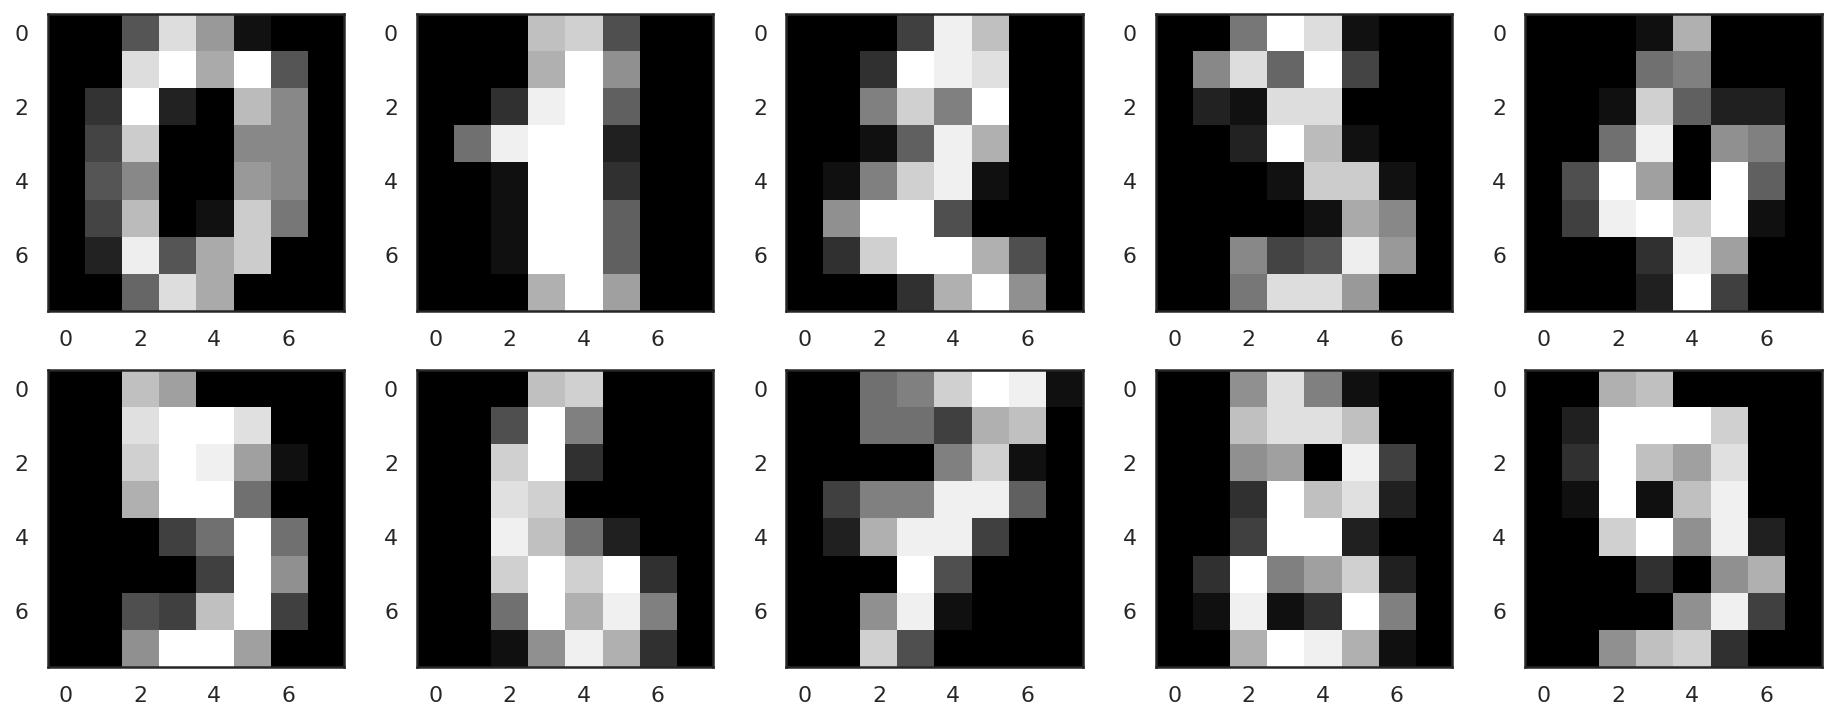

In [ ]:
with sns.axes_style("white"):
  plt.figure(figsize=(16, 6))
  for i in range(10):
      plt.subplot(2, 5, i + 1)
      plt.imshow(X[i,:].reshape([8,8]), cmap='gray');

Nos données ont 64 dimensions, mais nous allons les réduire à seulement 2 et voir que, même avec seulement 2 dimensions, nous pouvons clairement voir que les chiffres se séparent en clusters.

Projecting 64-dimensional data to 2D


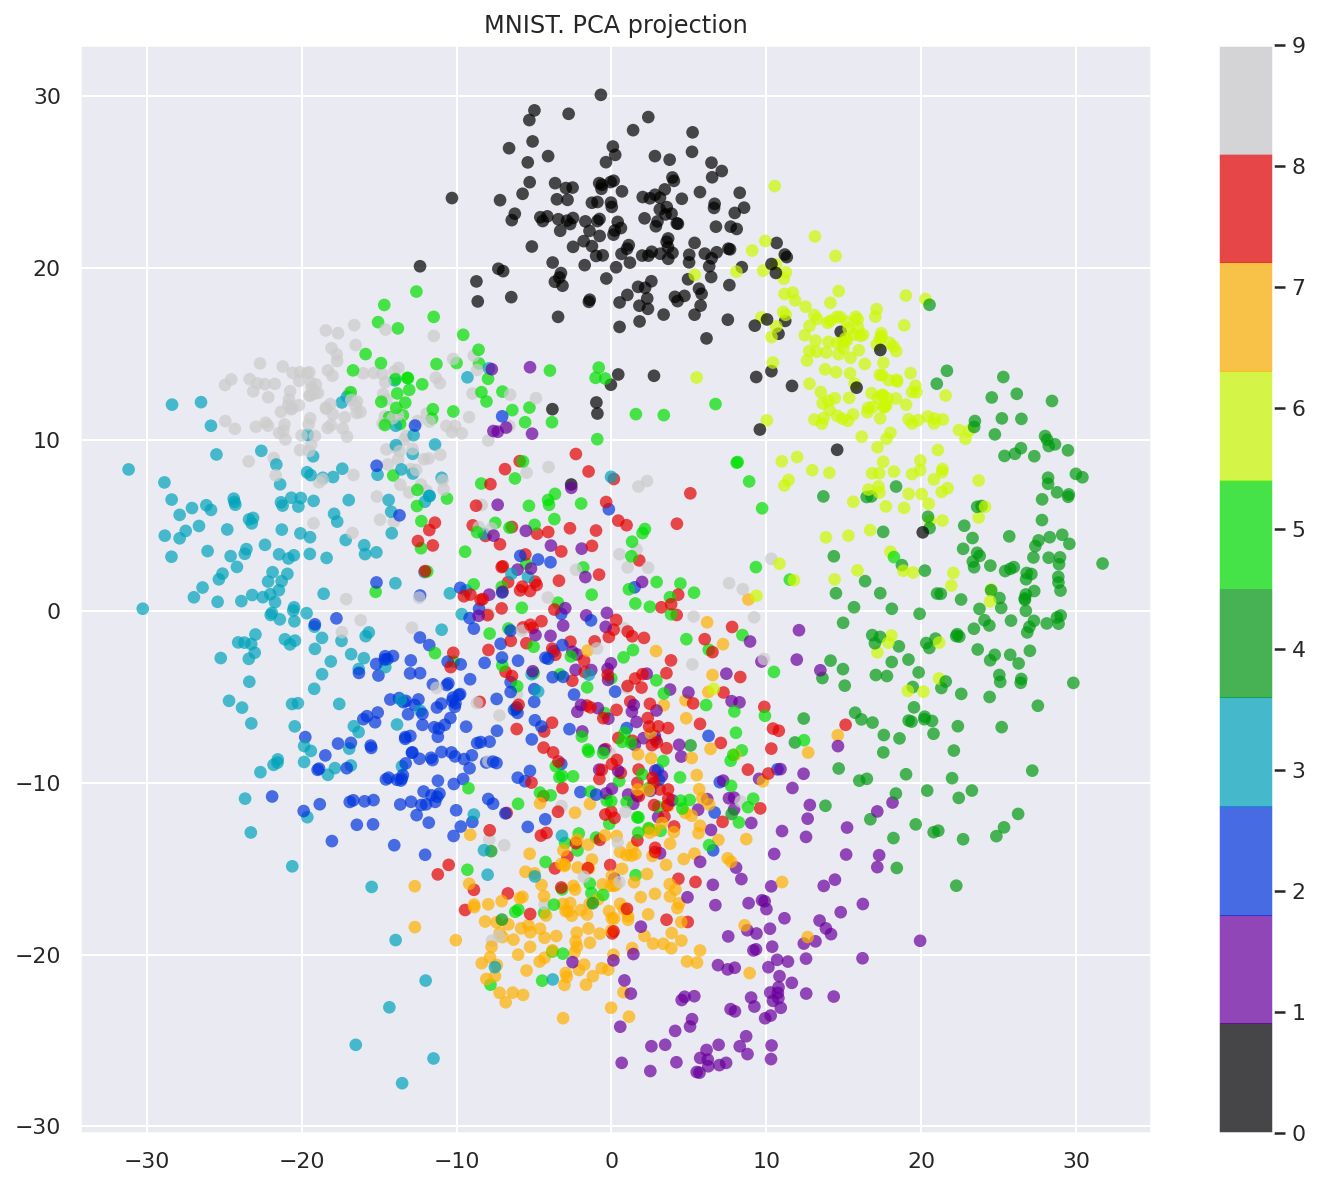

In [ ]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection');

Dans la pratique, nous choisirions le nombre de composants principaux de façon à pouvoir expliquer **90% de la dispersion initiale des données** (via le `explained_variance_ratio`). Ici, cela signifie conserver 20 composants principaux; par conséquent, nous réduisons la dimensionnalité de 64 entités à 20.

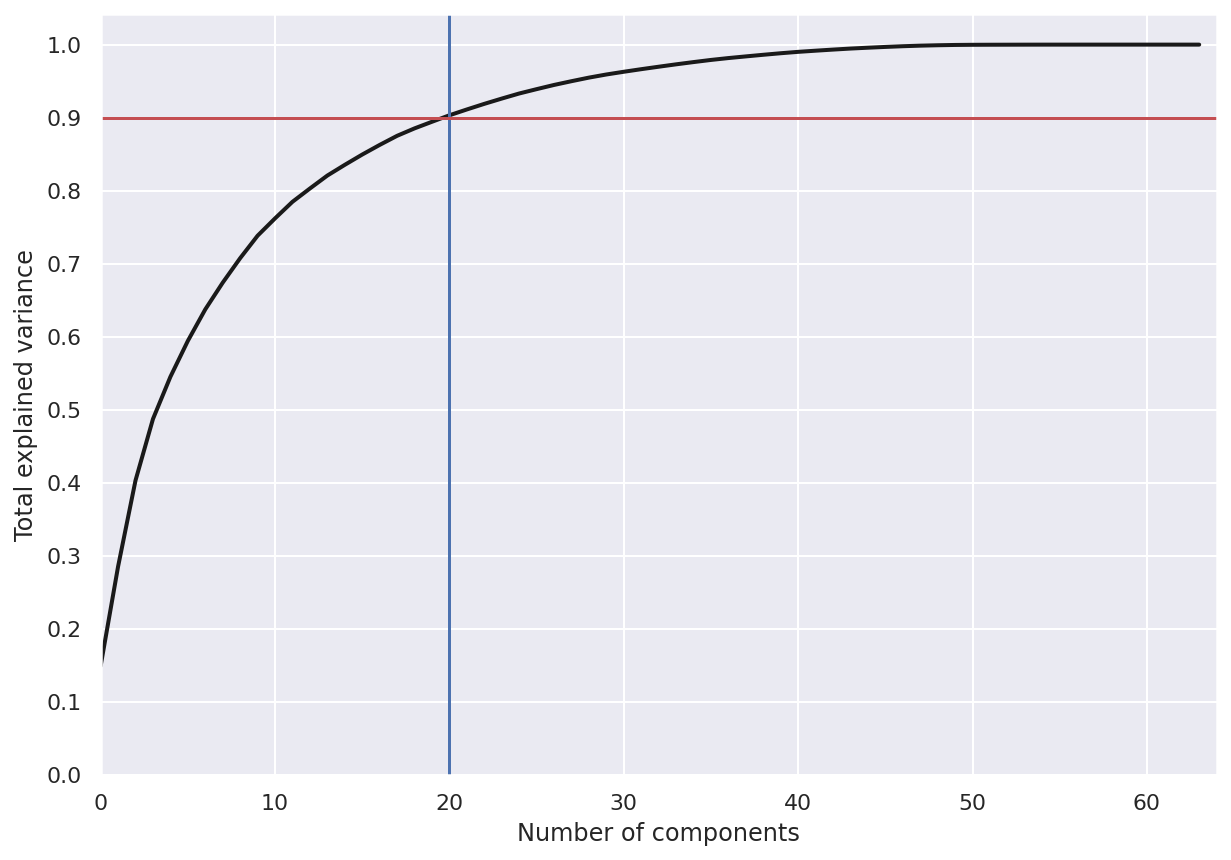

In [ ]:
pca = decomposition.PCA().fit(X)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 64)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(20, c='b')
plt.axhline(0.9, c='r')
plt.show();

## 2. Clustering

L'idée principale derrière le clustering est assez simple. Fondamentalement, nous nous disons: «J'ai ces points ici, et je peux voir qu'ils s'organisent en groupes. Ce serait bien de décrire ces choses plus concrètement et, quand un nouveau point arrive, de les affecter au bon groupe . " Cette idée générale encourage l'exploration et ouvre une variété d'algorithmes pour le clustering.

<figure><img align="center" src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png"> 
<figcaption> Les exemples des résultats de différents algorithmes de scikit-learn</figcaption>
</figure>

Les algorithmes répertoriés ci-dessous ne couvrent pas toutes les méthodes de clustering disponibles, mais ce sont les plus couramment utilisées.



### K-means

L'algorithme K-means est le plus populaire et le plus simple de tous les algorithmes de clustering. Voici comment cela fonctionne:
1. Sélectionnez le nombre de clusters $k$ que vous pensez être le nombre optimal.
2. Initialisez $k$ points comme des "centroïdes" au hasard dans l'espace de nos données.
3. Attribuez chaque observation à son centroïde le plus proche.
4. Mettez à jour les centroïdes au nouveau centre de l'ensemble des observations attribuées.
5. Répétez les étapes 3 et 4 un nombre fixe de fois ou jusqu'à ce que tous les centroïdes soient stables (c'est-à-dire qu'ils ne changent plus à l'étape 4).

Cet algorithme est facile à décrire et à visualiser.

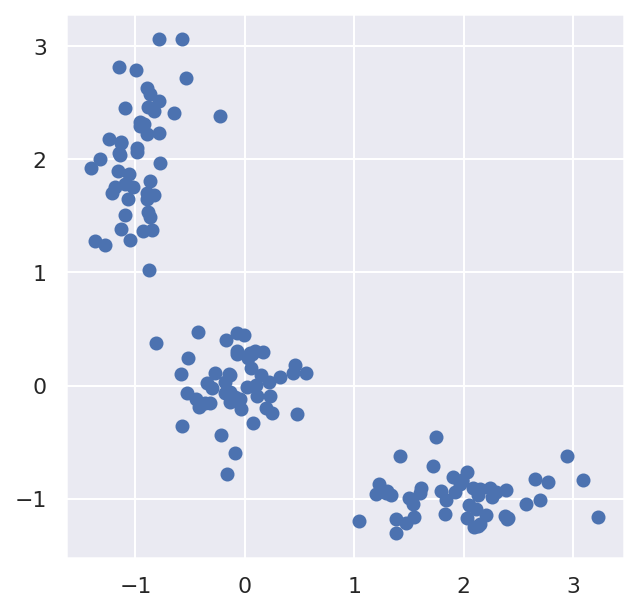

In [ ]:
# Let's begin by allocation 3 cluster's points
X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

plt.figure(figsize=(5, 5))
plt.plot(X[:, 0], X[:, 1], 'bo');

In [ ]:
# Scipy has function that takes 2 tuples and return
# calculated distance between them
from scipy.spatial.distance import cdist

# Randomly allocate the 3 centroids 
np.random.seed(seed=42)
centroids = np.random.normal(loc=0.0, scale=1., size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)

for i in range(3):
    # Calculating the distance from a point to a centroid
    distances = cdist(X, centroids)
    # Checking what's the closest centroid for the point
    labels = distances.argmin(axis=1)
    
    # Labeling the point according the point's distance
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)
    
    cent_history.append(centroids)

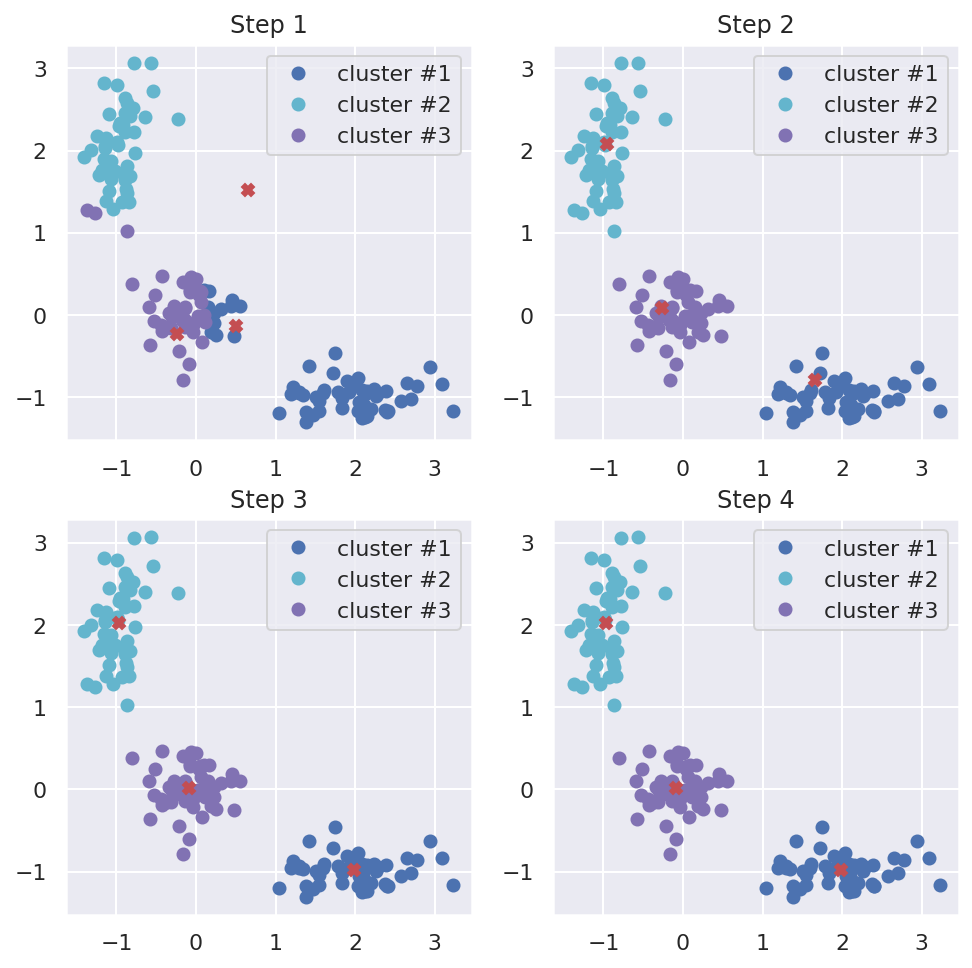

In [ ]:
# Let's plot K-means
plt.figure(figsize=(8, 8))
for i in range(4):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)
    
    plt.subplot(2, 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1));

Nous avons utilisé la distance euclidienne, mais l'algorithme convergera avec toute autre métrique. Vous pouvez non seulement faire varier le nombre d'étapes ou les critères de convergence, mais également la mesure de distance entre les points et les centroïdes de cluster.

Une autre "caractéristique" de cet algorithme est sa sensibilité aux positions initiales des centroïdes du cluster. Vous pouvez exécuter l'algorithme plusieurs fois, puis faire la moyenne de tous les résultats du centroïde.

#### Choix du nombre de clusters pour K-means

Contrairement aux tâches d'apprentissage supervisé telles que la classification et la régression, le clustering nécessite plus d'efforts pour choisir le critère d'optimisation. Habituellement, lorsque nous travaillons avec k-means, nous optimisons la somme des distances au carré entre les observations et leurs centroïdes.

$$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$

où $C$ - est un ensemble de clusters avec la puissance $K$, $\mu_k$ est un centre de gravité d'un cluster $C_k$.

Cette définition semble raisonnable - nous voulons que nos observations soient aussi proches que possible de leurs centroïdes. Mais, il y a un problème - l'optimum est atteint lorsque le nombre de centroïdes est égal au nombre d'observations, donc vous vous retrouveriez avec chaque observation comme son propre cluster séparé.

Afin d'éviter ce cas, nous devons choisir un certain nombre de clusters après quoi une fonction $J(C_k)$ diminue moins rapidement. Plus formellement,
$$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Regardons un exemple.

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [ ]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))


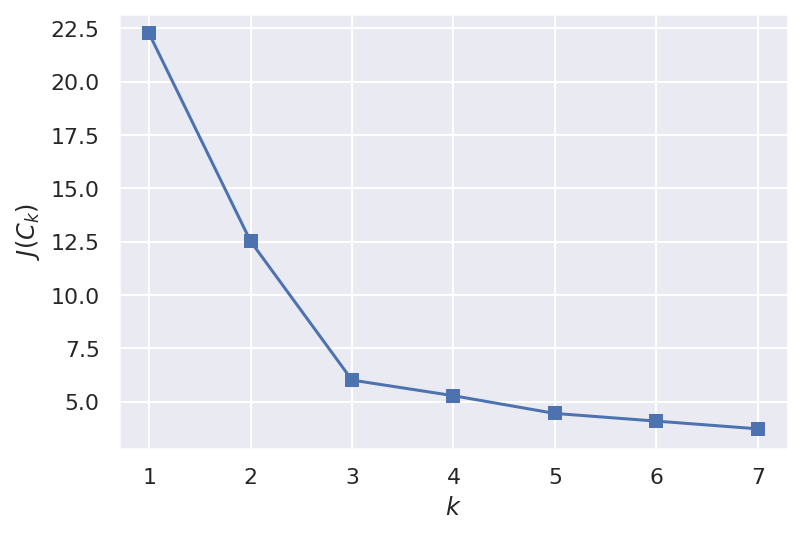

In [ ]:
plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Nous voyons que $J(C_k)$ diminue de manière significative jusqu'à ce que le nombre de clusters soit de 3 puis ne change plus autant. Cela signifie que le nombre optimal de clusters est de 3.

### Modèle de mélange gaussien

Le modèle de mélange gaussien (GMM) tente de trouver un mélange de distributions de probabilité gaussiennes multidimensionnelles qui modélisent le mieux n'importe quel ensemble de données d'entrée. 

Dans le cas le plus simple, GMMs peut être utilisé pour trouver des clusters de la même manière que k-means.



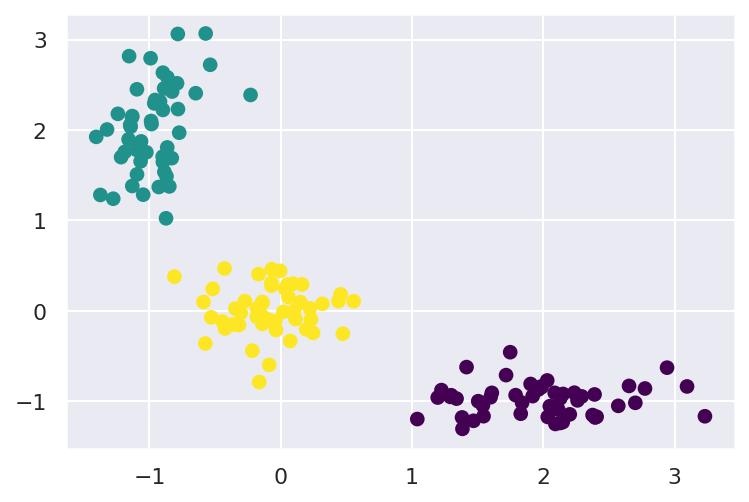

In [ ]:
X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

# plt.figure(figsize=(5, 5))
# plt.plot(X[:, 0], X[:, 1], 'bo');

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3).fit(X)
labels = gmm.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Le modèle de mélange gaussien est très similaire à k-means. Il utilise une approche de maximisation des attentes qui fait qualitativement ce qui suit:

*   Choisissez des suppositions de départ pour les positions et formes;
*   Répéter jusqu'à ce que cela converge :

> 1. *E-step*: pour chaque point, trouvez des poids codant la probabilité d'appartenance à chaque cluster.
> 2. *M-step*: pour chaque cluster, mettez à jour sa position, sa normalisation et sa forme en fonction de tous les points de données, en utilisant les poids.

En somme, chaque cluster est associé non pas à une sphère à bords durs, mais à un modèle gaussien lisse. Tout comme dans l'approche k-means expectation–maximization, cet algorithme peut parfois manquer la solution globalement optimale, et donc en pratique plusieurs initialisations aléatoires sont utilisées.

Créons une fonction qui nous aidera à visualiser les positions et les formes des clusters GMM en dessinant des ellipses basées sur la sortie GMM:

In [ ]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

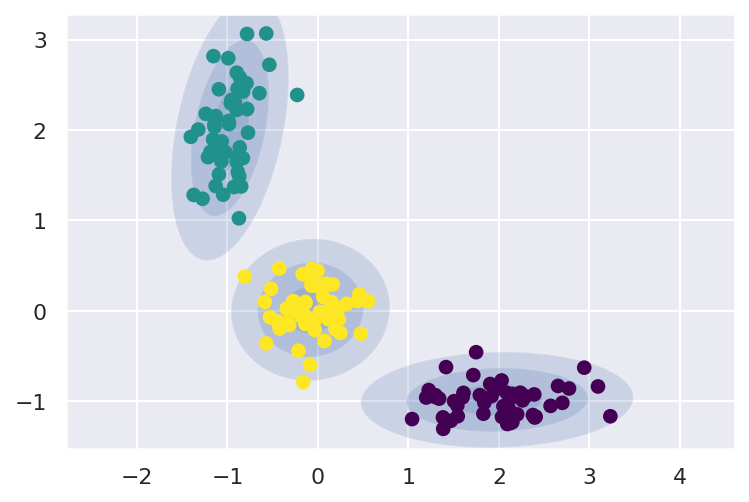

In [ ]:
gmm = GaussianMixture(n_components=3).fit(X)
plot_gmm(gmm, X)

Par contre, pour k-means les formes de clusters obtenus doivent être circulaires, k-means n'a aucun moyen intégré de rendre compte des clusters oblongues ou elliptiques.

In [ ]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

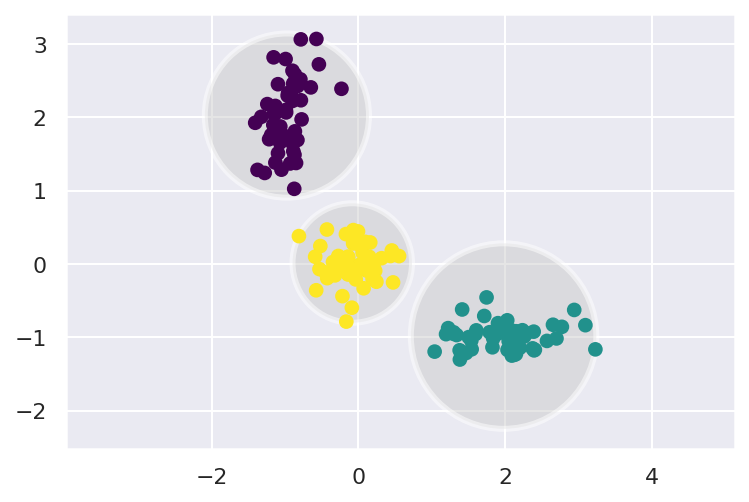

In [ ]:
kmeans = KMeans(n_clusters=3)
plot_kmeans(kmeans, X, n_clusters=3)

### Clustering agglomératif (hiérarchique)

L'algorithme suivant est le plus simple et le plus facile à comprendre parmi tous les algorithmes de clustering sans nombre fixe de clusters.


L'algorithme est assez simple:
1. Nous commençons par assigner chaque observation à son propre cluster
2. Ensuite, triez les distances par paires entre les centres des clusters dans l'ordre décroissant
3. Prenez les deux clusters voisins les plus proches et fusionnez-les, puis recalculez les centres
4. Répétez les étapes 2 et 3 jusqu'à ce que toutes les données soient fusionnées en un seul cluster

Le processus de recherche du cluster le plus proche peut être mené avec différentes méthodes de délimitation des observations:
1. Liaison unique :
$$d(C_i, C_j) = min_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$$
2. Lien complet :
$$d(C_i, C_j) = max_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$$
3. Lien moyen :
$$d(C_i, C_j) = \frac{1}{n_i n_j} \sum_{x_i \in C_i} \sum_{x_j \in C_j} ||x_i - x_j||$$
4. Liaison centroïde :
$$d(C_i, C_j) = ||\mu_i - \mu_j||$$

Le 3ème est le plus efficace en temps de calcul car il ne nécessite pas de recalculer les distances à chaque fusion des clusters.

Les résultats peuvent être visualisés comme un bel arbre de cluster (dendogramme) pour aider à reconnaître le moment où l'algorithme doit être arrêté pour obtenir des résultats optimaux. Il existe de nombreux outils Python pour construire ces dendogrammes pour le clustering agglomératif.

Prenons un exemple avec les clusters que nous avons obtenus de K-means:

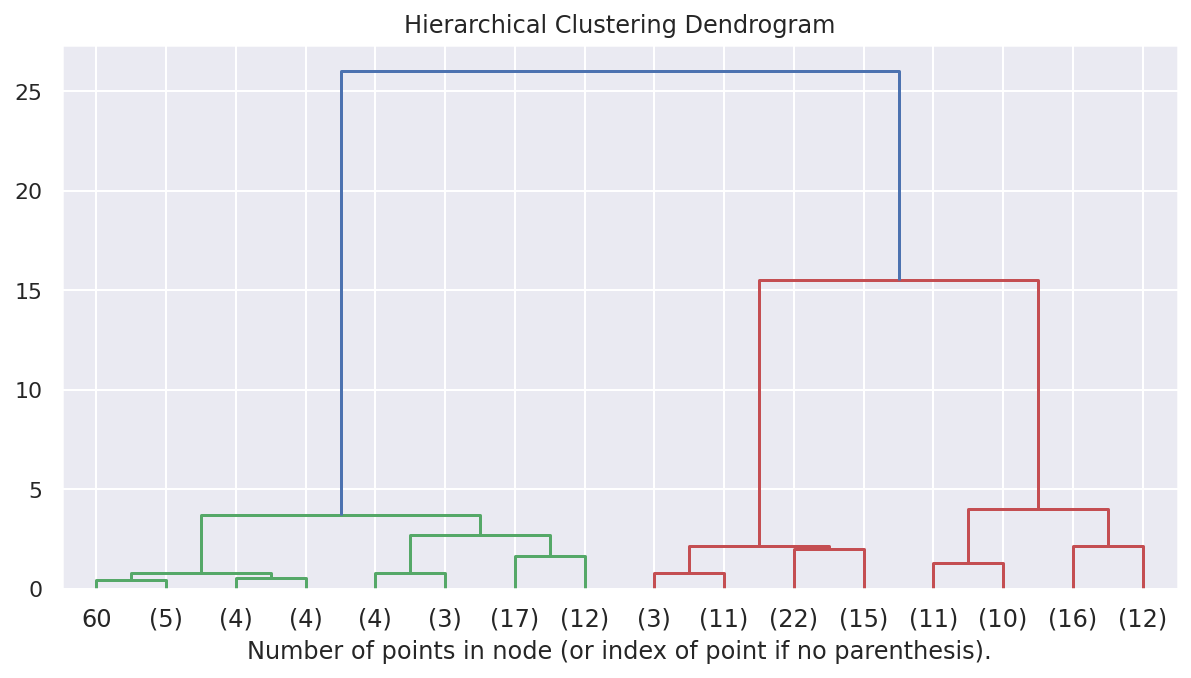

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

agg = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agg = agg.fit(X)

plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

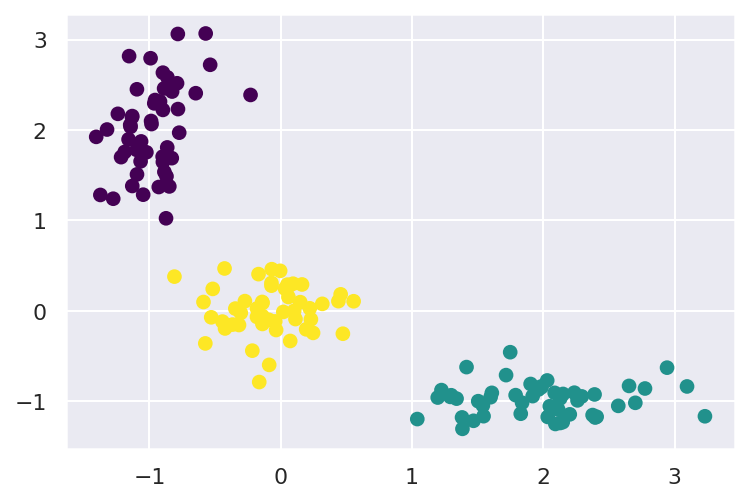

In [ ]:
agg = AgglomerativeClustering(n_clusters=3)
agg_labels = agg.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=agg_labels, s=40, cmap='viridis');

### Mesures de précision

Contrairement à la classification, il est difficile d'évaluer la qualité des résultats du clustering. Ici, une métrique ne peut pas dépendre des étiquettes mais uniquement de la qualité de la division. Deuxièmement, nous n'avons généralement pas de véritables étiquettes des observations lorsque nous utilisons le clustering.

Il existe des mesures de qualité *internes* et *externes*. Les métriques externes utilisent les informations sur la véritable séparation connue tandis que les métriques internes n'utilisent aucune information externe et évaluent la qualité des clusters en se basant uniquement sur les données initiales. Le nombre optimal de clusters est généralement défini par rapport à certaines métriques internes.

Toutes les métriques décrites ci-dessous sont implémentées dans `sklearn.metrics`.

**Adjusted Rand Index (ARI)**

Ici, nous supposons que les véritables étiquettes des objets sont connues. Cette métrique ne dépend pas des valeurs des étiquettes mais de la division du cluster de données. Soit $N$ le nombre d'observations dans un échantillon. Soit $a$ le nombre de paires d'observation avec les mêmes étiquettes et situées dans le même cluster, et que $b$ soit le nombre de paires d'observation avec des étiquettes différentes et situées dans différents clusters. L'indice Rand peut être calculé à l'aide de la formule suivante: $$\text{RI} = \frac{2(a + b)}{n(n-1)}.$$
En d'autres termes, il évalue une part de paires d'observation pour lesquelles ces divisions (résultat initial et clustering) sont cohérentes. L'indice Rand (RI) évalue la similitude des deux divisions du même échantillon. Pour que cet indice soit proche de zéro pour tout résultat de clustering avec n'importe quel $n$ et nombre de clusters, il est essentiel de le mettre à l'échelle, d'où l'indice Adjusted Rand Index: $$\text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\max(\text{RI}) - E[\text{RI}]}.$$

Cette métrique est symétrique et ne dépend pas de la permutation d'étiquette. Par conséquent, cet indice est une mesure des distances entre différentes divisions d'échantillon. $\text{ARI}$ prend des valeurs dans la plage $[-1, 1]$. Les valeurs négatives indiquent l'indépendance des divisions et les valeurs positives indiquent que ces divisions sont cohérentes (elles correspondent à $\text{ARI} = 1$).

**Adjusted Mutual Information (AMI)**

Cette métrique est similaire à $\text{ARI}$. Elle est également symétrique et ne dépend pas des valeurs et de la permutation des étiquettes. Il est défini par la fonction [entropie](https://en.wikipedia.org/wiki/Entropy_(information_theory) et interprète un échantillon divisé comme une distribution discrète (la probabilité d'affecter à un cluster est égal au pourcentage d'objets qu'il contient.) L'index $MI$ est défini comme l'[information mutuelle](https://en.wikipedia.org/wiki/Mutual_information) pour deux distributions, correspondant à l'échantillon divisé en grappes. Intuitivement, les informations mutuelles mesurent la part des informations communes aux deux clusters, c'est-à-dire comment les informations sur l'un d'entre eux diminuent l'incertitude de l'autre.

De la même manière que $\text{ARI}$, $\text{AMI}$ est défini. Cela nous permet de nous débarrasser de l'augmentation de l'indice $MI$ avec le nombre de clusters. Le $\text{AMI}$ se situe dans la gamme $[0, 1]$. Des valeurs proches de zéro signifient que les divisions sont indépendantes, et celles proches de 1 signifient qu'elles sont similaires (avec correspondance complète à $\text{AMI} = 1$).

**Homogénéité, exhaustivité, V-mesure**

Formellement, ces métriques sont également définies en fonction de la fonction d'entropie et de la fonction d'entropie conditionnelle, interprétant les répartitions d'échantillon comme des distributions discrètes: $$h = 1 - \frac{H(C\mid K)}{H(C)}, c = 1 - \frac{H(K\mid C)}{H(K)},$$
où $K$ est un résultat de clustering et $C$ est la division initiale. Par conséquent, $h$ évalue si chaque cluster est composé des mêmes objets de classe, et $c$ mesure dans quelle mesure les mêmes objets de classe s'adaptent aux clusters. Ces métriques ne sont pas symétriques. Les deux se situent dans la plage $[0, 1]$, et des valeurs plus proches de 1 indiquent des résultats de clustering plus précis. Les valeurs de ces métriques ne sont pas mises à l'échelle comme le sont les métriques $\text{ARI}$ ou $\text{AMI}$ et dépendent donc du nombre de clusters. Un résultat de clustering aléatoire n'aura pas de valeurs de mesures plus proches de zéro lorsque le nombre de clusters est suffisamment grand et le nombre d'objets est petit. Dans un tel cas, il serait plus raisonnable d'utiliser $\text{ARI}$. Cependant, avec un grand nombre d'observations (plus de 100) et un nombre de grappes inférieur à 10, ce problème est moins critique et peut être ignoré.

$V$-mesure (𝑉-measure) est une combinaison de $h$ et $c$ et est leur moyenne harmonique:
$$v = 2\frac{hc}{h+c}.$$
Il est symétrique et mesure la cohérence de deux résultats de regroupement.

**Silhouette**

Contrairement aux métriques décrites ci-dessus, ce coefficient n'implique pas la connaissance des véritables étiquettes des objets. Il nous permet d'estimer la qualité du clustering en utilisant uniquement l'échantillon initial sans étiquette et le résultat du clustering. Pour commencer, pour chaque observation, le coefficient de silhouette est calculé. Soit $a$ la moyenne de la distance entre un objet et d'autres objets au sein d'un cluster et $b$ la distance moyenne d'un objet aux objets du cluster le plus proche (différente de celle à laquelle appartient l'objet). Ensuite, la mesure de silhouette pour cet objet est $$s = \frac{b - a}{\max(a, b)}.$$

La silhouette d'un échantillon est une valeur moyenne des valeurs de silhouette de cet échantillon. Par conséquent, la distance de la silhouette montre dans quelle mesure la distance entre les objets d'une même classe diffère de la distance moyenne entre les objets de différents groupes. Ce coefficient prend des valeurs dans la plage $[-1, 1]$. Des valeurs proches de -1 correspondent à de mauvais résultats de clustering tandis que des valeurs plus proches de 1 correspondent à des clusters denses et bien définis. Par conséquent, plus la valeur de silhouette est élevée, meilleurs sont les résultats du clustering.

À l'aide de silhouette, nous pouvons identifier le nombre optimal de grappes $k$ (si nous ne le savons pas déjà à partir des données) en prenant le nombre de grappes qui maximise le coefficient de silhouette.

Pour conclure, examinons comment ces mesures fonctionnent avec le même jeu de données :

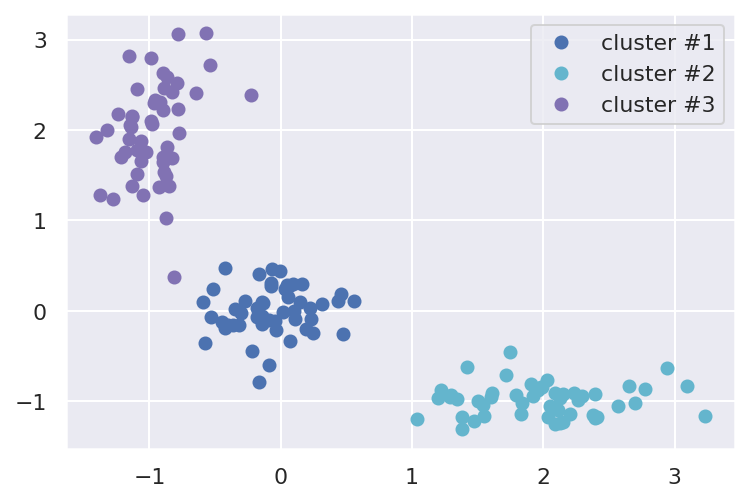

In [ ]:
X = np.zeros((150, 2))
y = np.zeros(150)

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)
y[:50] = 0

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)
y[50:100] = 1

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)
y[100:150] = 2

# data = datasets.load_digits()
# X, y = data.data, data.target


plt.plot(X[:50, 0], X[:50, 1], 'bo', label='cluster #1')
plt.plot(X[50:100, 0], X[50:100, 1], 'co', label='cluster #2')
plt.plot(X[100:150, 0], X[100:150, 1], 'mo', label='cluster #3')
plt.legend(loc=0)
plt.show()

In [ ]:
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

algorithms = []
algorithms.append(KMeans(n_clusters=3, random_state=1))
algorithms.append(AgglomerativeClustering(n_clusters=3))
algorithms.append(GaussianMixture(n_components=3))

data = []
for algo in algorithms:
    algo.fit(X)
    labels = algo.fit_predict(X)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, labels),
        'AMI': metrics.adjusted_mutual_info_score(y, labels),
        'Homogenity': metrics.homogeneity_score(y, labels),
        'Completeness': metrics.completeness_score(y, labels),
        'V-measure': metrics.v_measure_score(y, labels),
        'Silhouette': metrics.silhouette_score(X, labels)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['K-means','Agglomerative', 'GaussianMixture'])

results

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
K-means,0.979932,0.969818,0.970132,0.97025,0.970191,0.721038
Agglomerative,0.979932,0.969818,0.970132,0.97025,0.970191,0.721038
GaussianMixture,0.979932,0.969818,0.970132,0.97025,0.970191,0.721038


## 3. Liens utiles
- Overview of clustering methods in the [scikit-learn doc](https://scikit-learn.org/stable/modules/clustering.html).
- [Q&A](http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues) for PCA with examples